## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline


import matplotlib

matplotlib.rcdefaults()
matplotlib.rcParams['text.usetex'] = True            # Use LaTeX for text rendering

# Update font settings
matplotlib.rcParams.update({
    'font.family': 'serif',                          # Use serif font family
    'font.serif': 'Palatino',                        # Use Palatino as the standard font
    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{mathpazo}',  # Use the amsmath and mathpazo package for LaTeX
})

# Customize the figure size
matplotlib.rcParams['figure.figsize'] = (8, 6)   # Set the default figure size

# Customize axes
matplotlib.rcParams['axes.labelsize'] = 30       # Axis label font size
matplotlib.rcParams['axes.titlesize'] = 30       # Axis title font size
matplotlib.rcParams['axes.titlepad'] = 15        # Axis title padding
matplotlib.rcParams['axes.linewidth'] = 2        # Axis line width

# Customize ticks
matplotlib.rcParams['xtick.labelsize'] = 22      # X-axis tick label size
matplotlib.rcParams['ytick.labelsize'] = 22      # Y-axis tick label size
matplotlib.rcParams['xtick.major.width'] = 1.2   # X-axis major tick width
matplotlib.rcParams['ytick.major.width'] = 1.2   # Y-axis major tick width
matplotlib.rcParams['xtick.minor.size'] = 4      # X-axis minor tick size
matplotlib.rcParams['ytick.minor.size'] = 4      # Y-axis minor tick size
matplotlib.rcParams['xtick.major.size'] = 8      # X-axis major tick size
matplotlib.rcParams['ytick.major.size'] = 8      # Y-axis major tick size

# Customize legend
matplotlib.rcParams['legend.fontsize'] = 26      # Legend font size
matplotlib.rcParams['legend.frameon'] = True     # Enable/Disable the frame around the legend

# Customize grid
matplotlib.rcParams['grid.color'] = 'gray'       # Grid color
matplotlib.rcParams['grid.linestyle'] = '-'      # Grid line style
matplotlib.rcParams['grid.linewidth'] = 0.5      # Grid line width

# Customize lines
matplotlib.rcParams['lines.linewidth'] = 2.5       # Line width
matplotlib.rcParams['lines.markersize'] = 10        # Marker size

# Change figure and axes background colors
matplotlib.rcParams['figure.facecolor'] = 'white'    # Figure background color
matplotlib.rcParams['axes.facecolor'] = 'white'      # Axes background color

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [2]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)

In [3]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The length of the data without the rows with nan value is: {}'.format(len(original_data)))

The length of the data with all rows is : 79672
The length of the data without the rows with nan value is: 79661


In [4]:
data_features = original_data.copy()
data_features['adopted'] = data_features.outcome_type.apply(lambda r: 1 if r=='Adoption' else 0)
data_features.drop("outcome_type", axis = 1, inplace=True)
data_features.head()

,sex_upon_outcome,age_upon_outcome_(years),animal_type,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,adopted
0,Neutered Male,10.0,Dog,Normal,Stray,Neutered Male,10.0,2017,1.0,0.588194,0
1,Neutered Male,7.0,Dog,Normal,Public Assist,Neutered Male,7.0,2014,2.0,1.259722,0
2,Neutered Male,6.0,Dog,Normal,Public Assist,Neutered Male,6.0,2014,3.0,1.113889,0
3,Neutered Male,10.0,Dog,Normal,Owner Surrender,Neutered Male,10.0,2014,1.0,4.970139,0
4,Neutered Male,16.0,Dog,Injured,Public Assist,Neutered Male,16.0,2013,1.0,0.119444,0


In [5]:
def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio  # create a mask to randomly split the data
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [6]:
[train, test] = split_set(data_features)

In [7]:
categorical_columns = ['sex_upon_outcome', 'animal_type', 'intake_condition', 'intake_type', 'sex_upon_intake']
train_categorical = pd.get_dummies(train, columns=categorical_columns)
train_categorical.columns

Index(['age_upon_outcome_(years)', 'age_upon_intake_(years)', 'intake_year',
       'intake_number', 'time_in_shelter_days', 'adopted',
       'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male',
       'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female',
       'sex_upon_outcome_Unknown', 'animal_type_Bird', 'animal_type_Cat',
       'animal_type_Dog', 'animal_type_Other', 'intake_condition_Aged',
       'intake_condition_Feral', 'intake_condition_Injured',
       'intake_condition_Normal', 'intake_condition_Nursing',
       'intake_condition_Other', 'intake_condition_Pregnant',
       'intake_condition_Sick', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'intake_type_Wildlife',
       'sex_upon_intake_Intact Female', 'sex_upon_intake_Intact Male',
       'sex_upon_intake_Neutered Male', 'sex_upon_intake_Spayed Female',
       'sex_upon_intake_Unknown'],
      dtype='object')

The features in the testing set must be matched with the traning set.

In [8]:
# Make sure we use only the features available in the training set
test_categorical = pd.get_dummies(test, columns=categorical_columns)[train_categorical.columns]

In [9]:
train_label = train_categorical.adopted
train_features = train_categorical.drop('adopted', axis=1)
print('Length of the train dataset : {}'.format(len(train)))

test_label = test_categorical.adopted
test_features = test_categorical.drop('adopted', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 63760
Length of the test dataset : 15901


In [10]:
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
# Standardize the training set
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c]

# Standardize the testing set
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

train_features_std.head()

,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,...,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,2.714958,2.733929,1.199208,-0.277274,-0.385731,-0.363235,-0.373286,1.347582,-0.687616,-0.304768,...,-0.055101,-0.480158,-0.258335,0.649153,-0.213313,-0.650959,-0.684946,2.307800,-0.403407,-0.304768
1,1.333879,1.349330,-1.103294,4.073945,-0.373190,-0.363235,-0.373286,1.347582,-0.687616,-0.304768,...,-0.055101,-0.480158,3.870881,-1.540446,-0.213313,-0.650959,-0.684946,2.307800,-0.403407,-0.304768
2,2.714958,2.733929,-1.103294,-0.277274,-0.281188,-0.363235,-0.373286,1.347582,-0.687616,-0.304768,...,-0.055101,2.082615,-0.258335,-1.540446,-0.213313,-0.650959,-0.684946,2.307800,-0.403407,-0.304768
3,4.786577,4.810828,-1.870795,-0.277274,-0.396915,-0.363235,-0.373286,1.347582,-0.687616,-0.304768,...,-0.055101,-0.480158,3.870881,-1.540446,-0.213313,-0.650959,-0.684946,2.307800,-0.403407,-0.304768
4,4.441307,4.464678,-1.870795,-0.277274,-0.378988,-0.363235,-0.373286,-0.742058,1.454277,-0.304768,...,-0.055101,-0.480158,-0.258335,0.649153,-0.213313,-0.650959,-0.684946,-0.433306,2.478847,-0.304768


## B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [11]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')


def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [12]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std,train_label)

LogisticRegression(max_iter=10000)

In [13]:
prediction_proba = logistic.predict_proba(test_features_std)

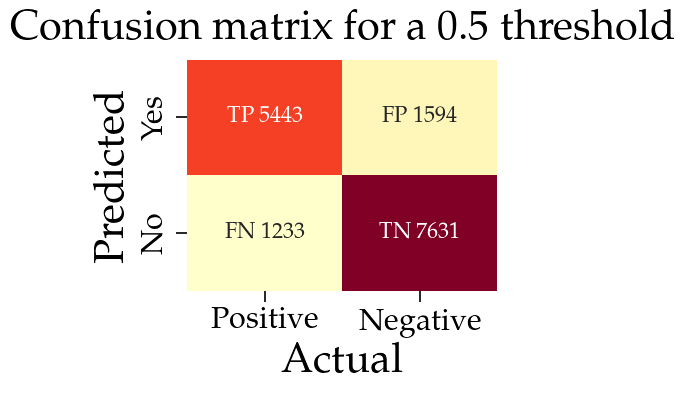

In [14]:
confusion_matrix_05 = compute_confusion_matrix(test_label, prediction_proba, 0.5 )
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')
plt.show()

In [15]:
[t, accuracy, precision_positive, recall_positive, F1_score_positive, \
    precision_negative, recall_negative, F1_score_negative] = compute_all_score(confusion_matrix_05)

print("The accuracy of this model is {0:1.3f}".format(accuracy))
print("For the positive case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_positive, recall_positive, F1_score_positive))
print("For the negative case, the precision is {0:1.3f}, the recall is {1:1.3f} and the F1 score is {2:1.3f}"\
      .format(precision_negative, recall_negative, F1_score_negative))

The accuracy of this model is 0.822
For the positive case, the precision is 0.773, the recall is 0.815 and the F1 score is 0.794
For the negative case, the precision is 0.861, the recall is 0.827 and the F1 score is 0.844


### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [16]:
threshold = np.linspace(0, 1, 100)

In [17]:
columns_score_name = ['Threshold', 'Accuracy', 'Precision P', 'Recall P', 'F1 score P', \
                                              'Precision N', 'Recall N', 'F1 score N']
threshold_score = pd.concat([pd.DataFrame([compute_all_score(compute_confusion_matrix(test_label, prediction_proba, t ),t)]\
                                             , columns=columns_score_name) for t in threshold], ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

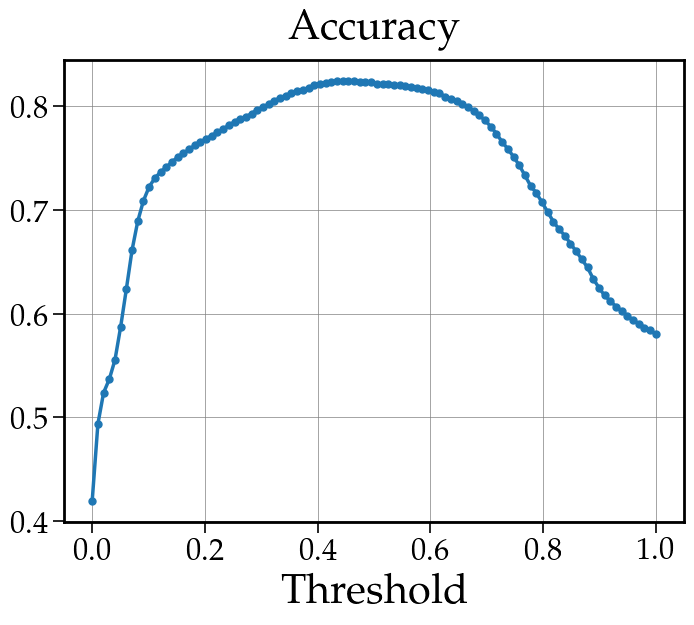

In [18]:
threshold_score['Accuracy'].plot(grid=True, marker='.').set_title('Accuracy')
plt.show()

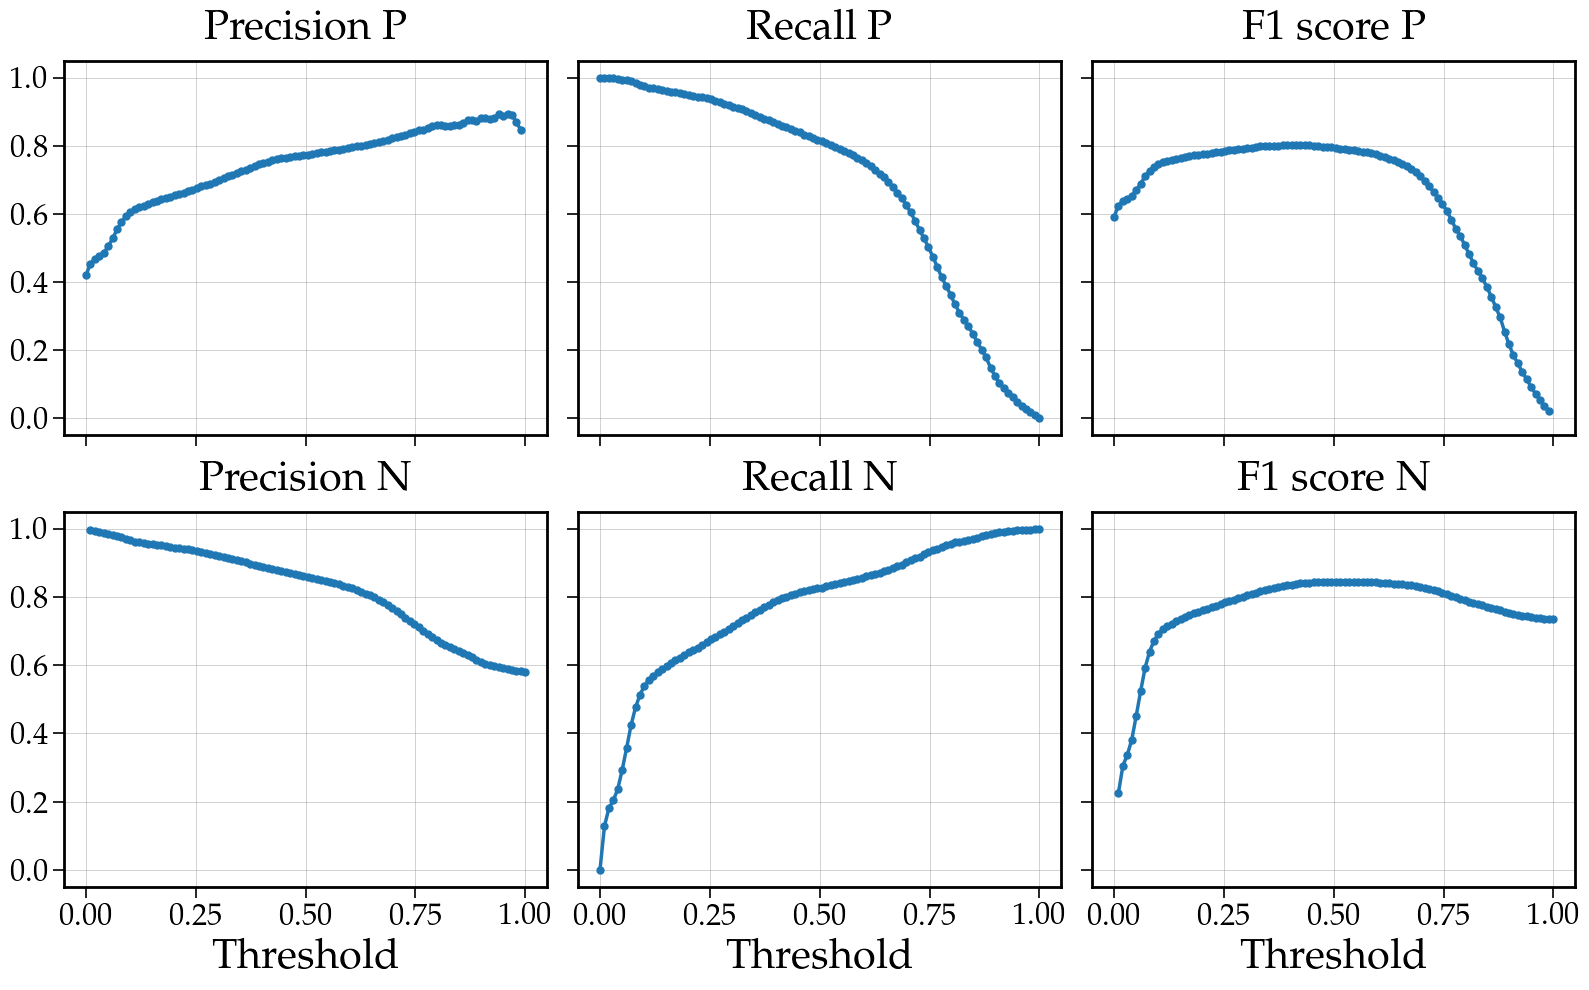

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(16,10))

col_plot = ['Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']

major_ticks = np.linspace(0,1,5)

for axe, col in zip(axs.flat, col_plot):
    threshold_score[col].plot(ax=axe, grid=True, marker='.')
    axe.set_title(col)
    axe.set_xticks(major_ticks)    
    axe.grid(which='major', alpha=0.5)
    plt.tight_layout()
plt.show()

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

In [20]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std, train_label)

LogisticRegression(max_iter=10000)

In [21]:
tmp = []
for name, value in zip(train_features_std.columns, logistic.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")
features_coef.head()

,name,value
1,age_upon_intake_(years),-2.140632
6,sex_upon_outcome_Intact Male,-0.766936
26,intake_type_Wildlife,-0.699629
5,sex_upon_outcome_Intact Female,-0.692491
31,sex_upon_intake_Unknown,-0.489844


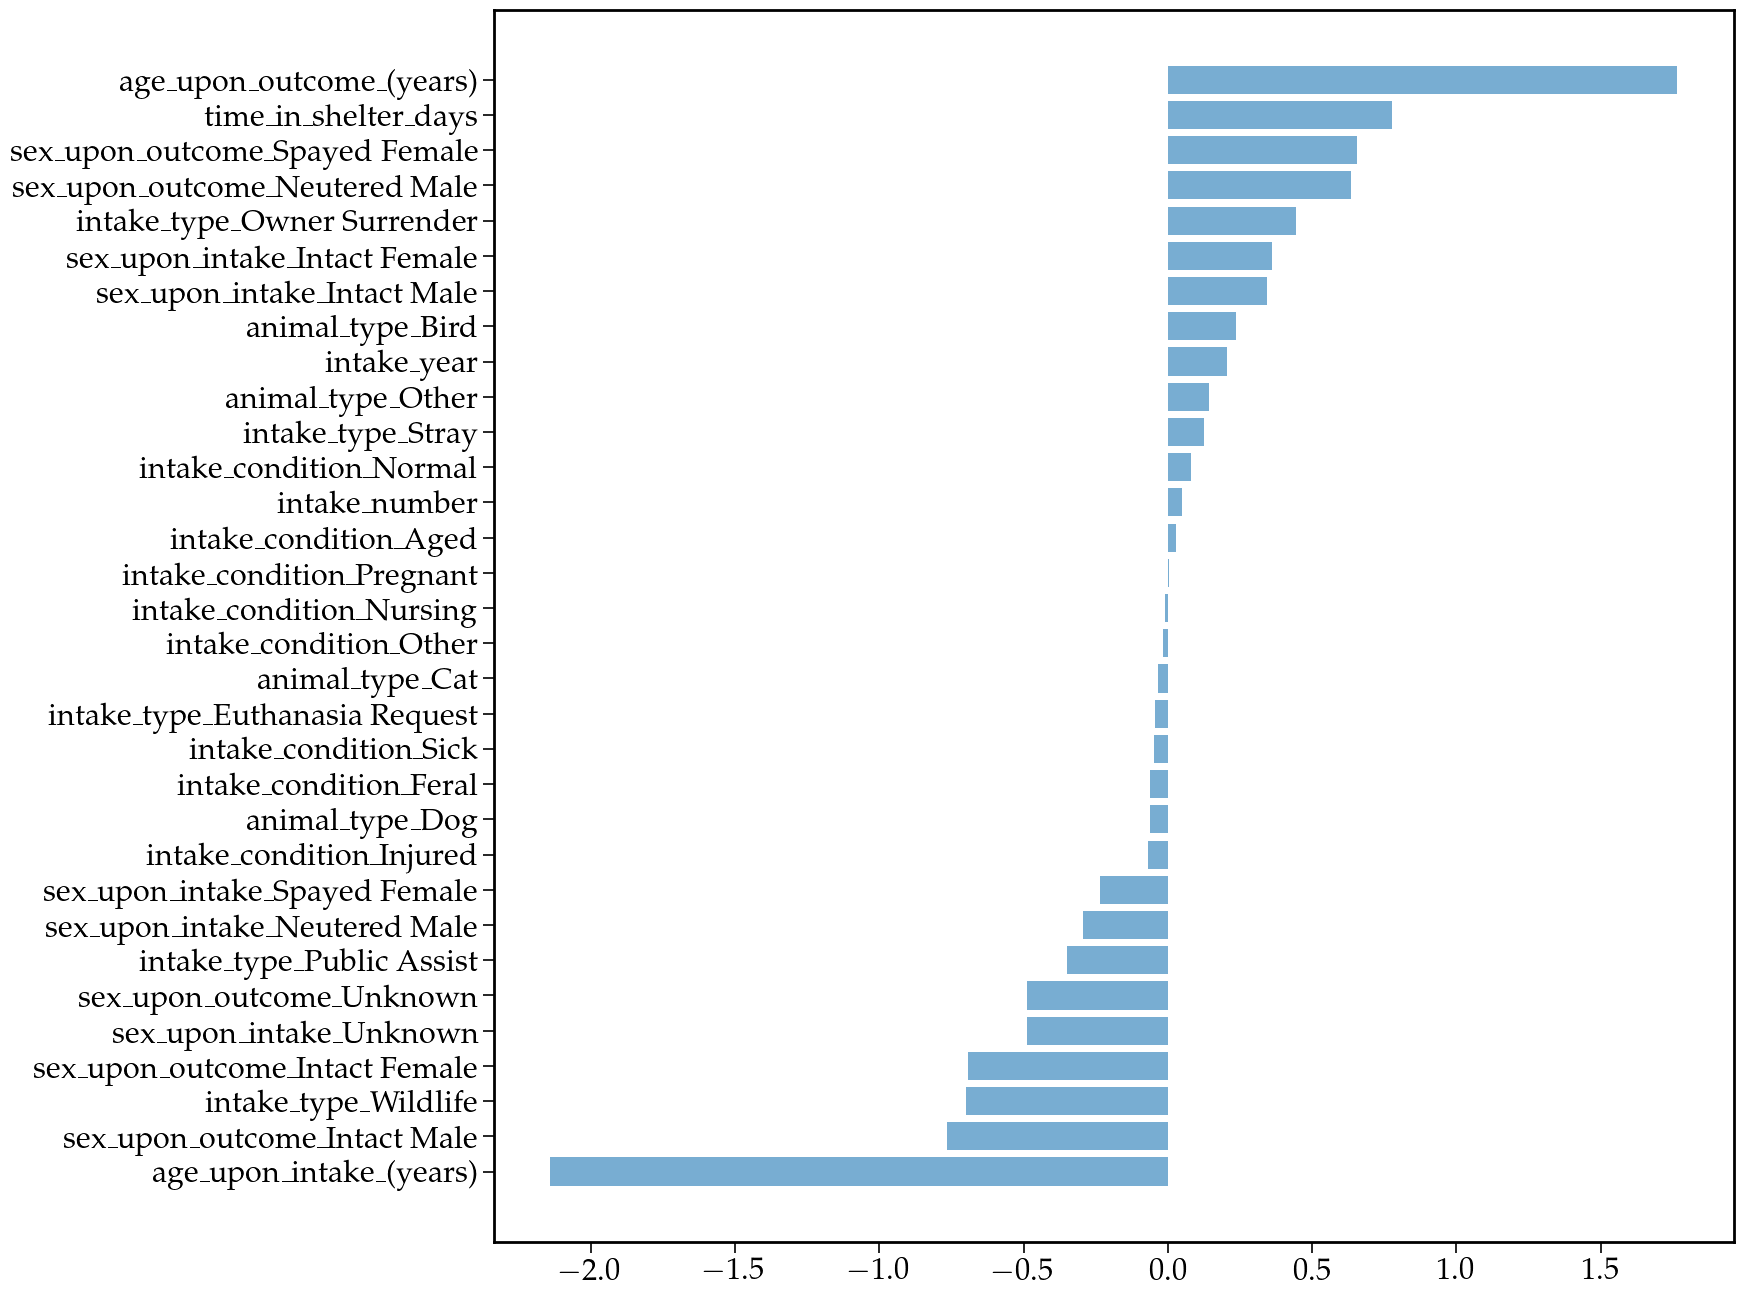

In [22]:
plt.subplots(figsize=(16,16))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# Quiz

## Questions 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- **a) F1 Score**
- b) Recall
- c) Precision
- d) Accuracy

**Why F1 Score?**

The F1 Score is the harmonic mean of precision and recall, balancing the trade-off between these two metrics.
It is particularly useful when the dataset has unbalanced classes, as it **considers both false positives and false negatives**, providing a single number that **reflects the model's performance on the minority class**.

**Why not the others?**

b) Recall: Focuses only on minimizing false negatives, which can be misleading if false positives are also important (common in unbalanced datasets).

c) Precision: Focuses only on minimizing false positives, ignoring false negatives, which can be crucial in detecting the minority class.

d) Accuracy: Can be misleading in unbalanced datasets because it is dominated by the majority class. For example, if 95% of the data belongs to one class, a model predicting the majority class 100% of the time will have 95% accuracy but fail to identify the minority class entirely.

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- **d) True positive rate is 0.95**

- Accuracy = number of correct predictions / total number of predictions = (50+100) / (50+10+5+100) = 150 / 165 = 0.91
- True positive rate = number of true positive predictions / total number of actual positive cases = 100 / (5+100) = 100 / 105 = 0.95
- False positive rate = number of false positive predictions / total number of actual negative cases = 10 / (50+10) = 10 / 60 = 0.17